# Analyzing LendingClub data

### Janos Botyanszki. Fellow, Insight Data Science


Lending Club is an originator of peer-to-peer (P2P) loans, which enable individuals to take out personal, business, or auto loans from investors without the involvement of a bank. P2P lending is considered to be an uncorrelated asset class, which is useful for investors seeking to diversify their portfolios. Lending Club is an online marketplace connecting the lenders and borrowers of the P2P relationship, and is also tasked with credit checking the borrowers.   

In this notebook, I analyze data from Lending Club during the 2007 - 2015 range. I explore the data, look at some business analytics questions, and build a model to improve returns. 


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as mno
import matplotlib.pyplot as plt

datafile = 'loan.csv'
data = pd.read_csv(datafile)

/Users/janos/.local/share/virtualenvs/LendingClub-4R0Ub5G7/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Exploration 

My approach for data exploration is the following:

* Get a general idea for what data are provided
* Make a plan about missing data
  - Check data types
  - Visualize completeness of data
  - Look for imputed values
  - Make a decision about how to handle incomplete/imputed data
* Explore some possible aggregations to summarize the data
  


## First look

In [3]:
print(data.columns)
data.head()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


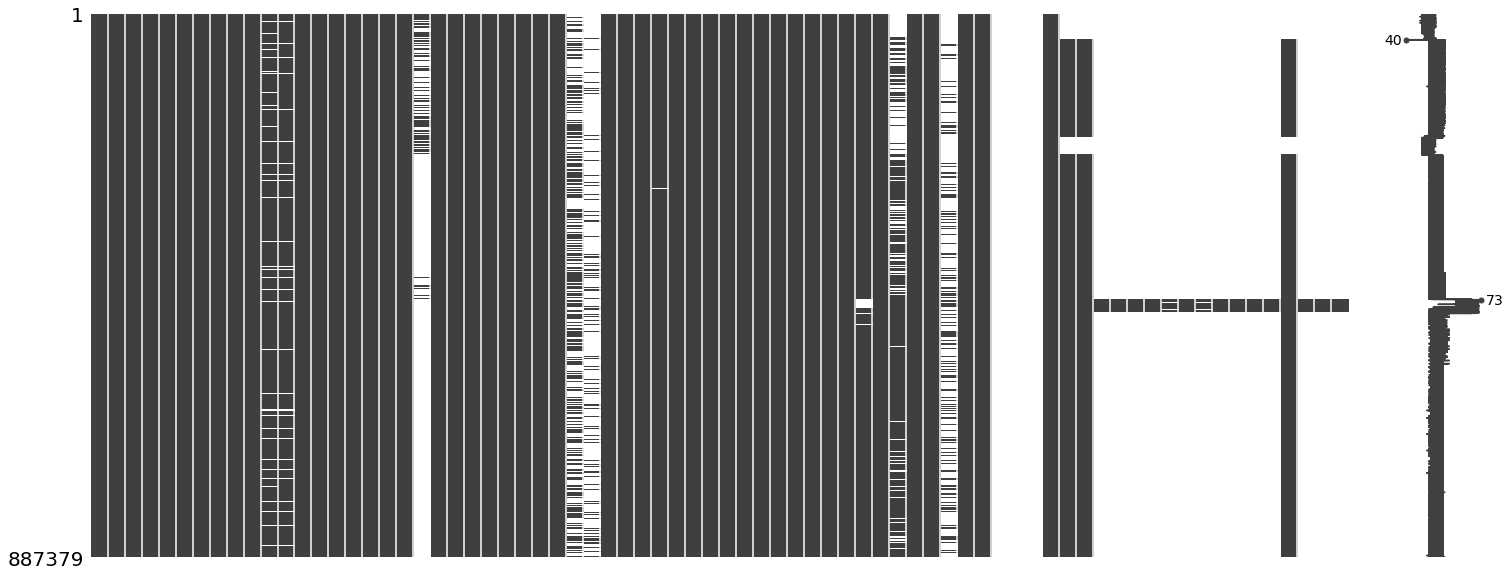

In [4]:
mno.matrix(data)

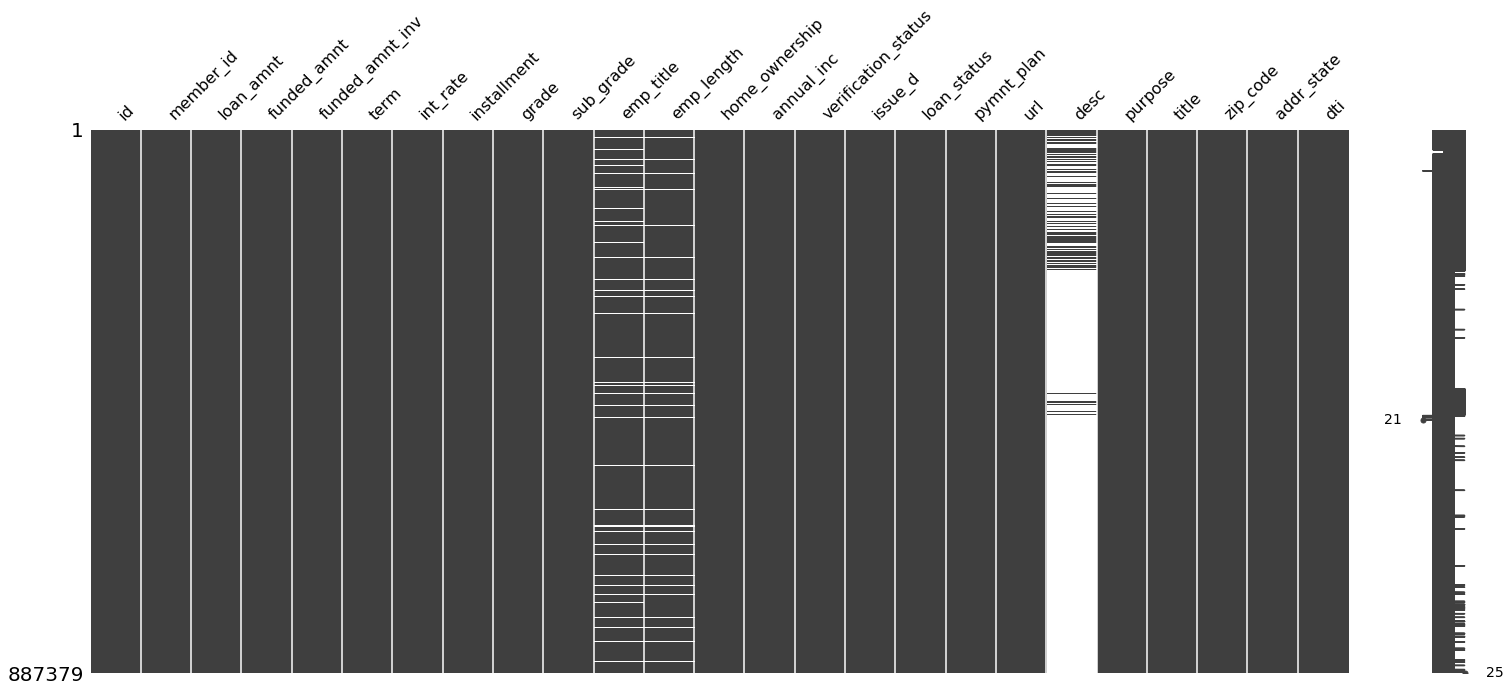

In [5]:
# lots of missing data; take a closer look
mno.matrix(data.iloc[:,0:25])

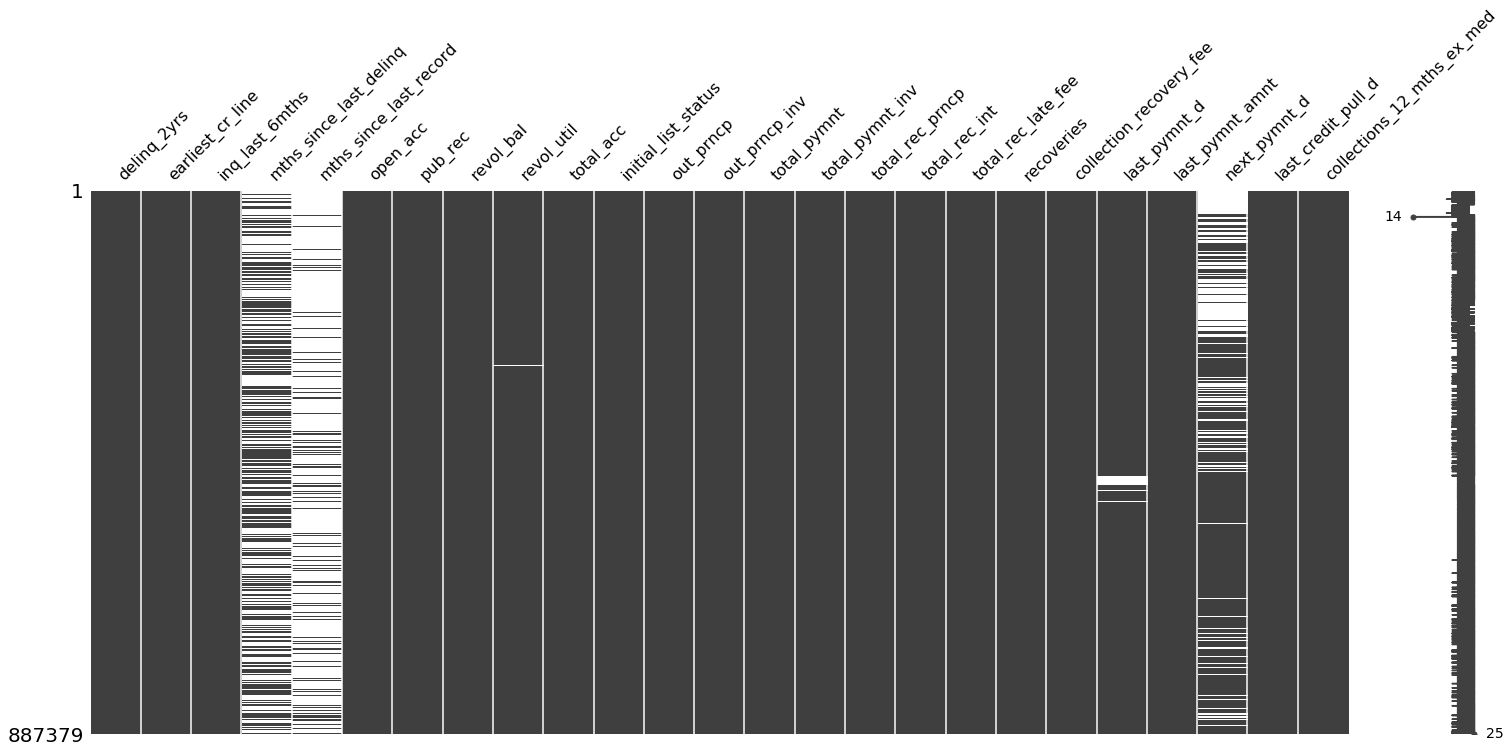

In [6]:
# looks like the fields about employment and the description of the loan are often missing. 
# We will not use need for analysis. We may be able to use them for modeling, but let's try without first.

mno.matrix(data.iloc[:,25:50])

In [7]:
# mths_since_last_delinq: keep; assume that NA means the person has not been delinquent
# mths_since_last_record: seems to be related to public notices on bankrupcy, foreclosures, etc.
#    keep; assume NA means no public notices

print(min(data.mths_since_last_delinq[~data.mths_since_last_delinq.isna()]))
print(min(data.mths_since_last_record[~data.mths_since_last_record.isna()]))

# add a dummy value for the above two
data.mths_since_last_delinq.fillna(-1, inplace=True)
data.mths_since_last_record.fillna(-1, inplace=True)

print(data.loc[(data.mths_since_last_record == -1)].shape)
print(data.loc[(data.mths_since_last_record == -1) & (data.pub_rec > 0)].shape)
# out of the 750k rows with missing mnth_since_last_record data, none have a public record. 
# so, the above assumption is valid


# revol_util
print(data.loc[data.revol_util.isna()].shape)
# 502 rows missing; it might be OK to drop, but let's wait until we actually have to use this col

# last_pymnt_d: might be NA if the borrower is new to LC
# next_pymnt_d: might be NA if borrower has paid off credit
print(data.last_pymnt_d[0], data.loc[~data.next_pymnt_d.isna()].iloc[0].next_pymnt_d)
# need to parse these columns to datetime format before using them


0.0
0.0
(750326, 74)
(0, 74)
(502, 74)
Jan-2015 Feb-2016


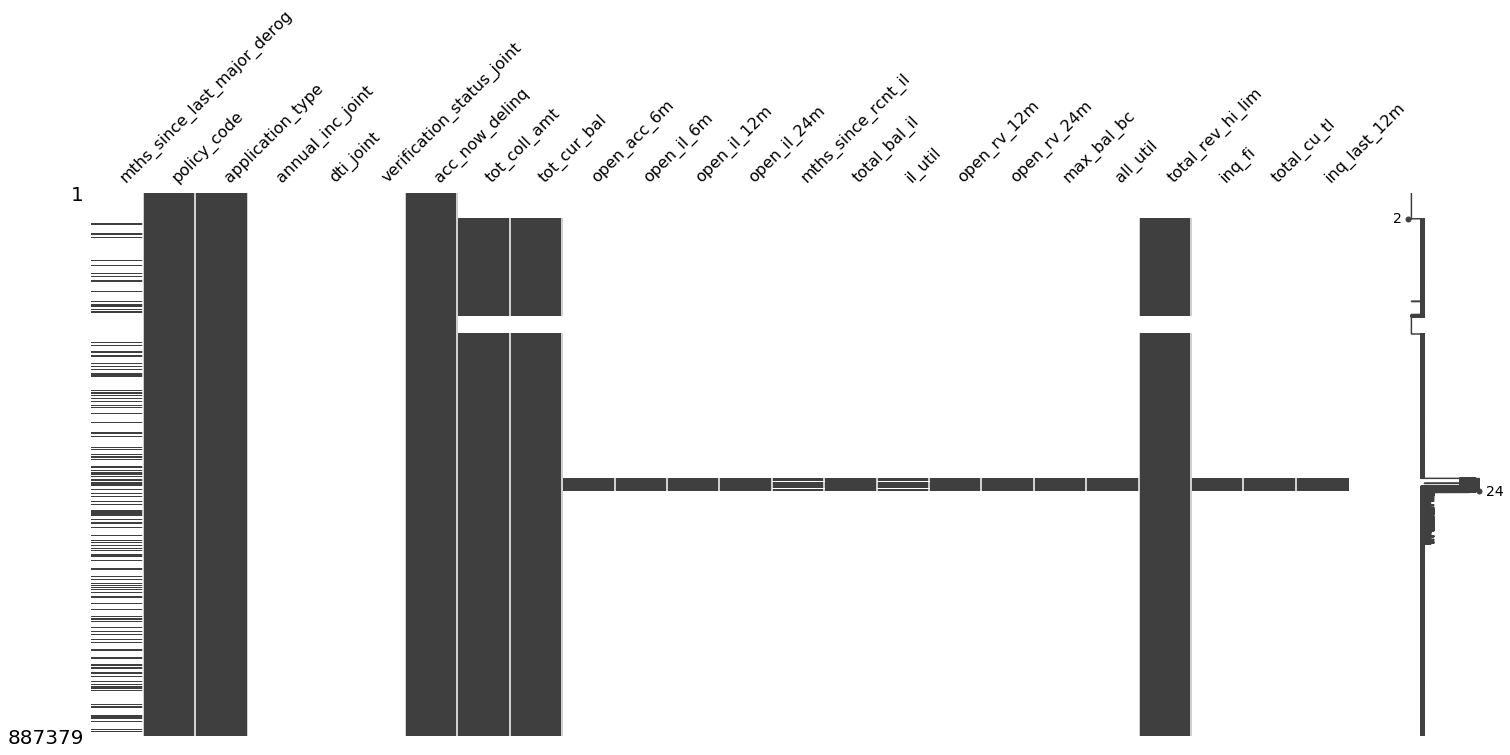

In [8]:
mno.matrix(data.iloc[:,50:])

In [9]:
# mths_since_last_derog: keep, assume no derogatory ratings if NA
data.mths_since_last_major_derog.fillna(-1, inplace=True)

# total_coll_amt: could be NA if never delinquent, but it should be 0.0 in that case. 
print(min(data.loc[~data.tot_coll_amt.isna()].tot_coll_amt))
print(data.loc[data.tot_coll_amt.isna()].shape)
print(data.loc[data.tot_coll_amt.isna()].loc[data.mths_since_last_delinq > -1].shape)
# of the 70k that have an NA in this column, 25k have had a previous delinquency. 
# so we can't fill NA with 0.0. Better to just ignore this column or impute with a
# dummy value like -1 if we really need it for modeling
# the same rows seem to be missing tot_cur_bal and tot_rev_hi_lim, so impute those as well
data.tot_coll_amt.fillna(-1.0, inplace=True)
data.tot_cur_bal.fillna(-1.0, inplace=True)
data.total_rev_hi_lim.fillna(-1.0, inplace=True)

# missing all or most data from the following cols, drop them from df
cols_to_drop = (['emp_title', 'emp_length', 'desc', 'annual_inc_joint', 'dti_joint', 
                 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 
                 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 
                 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 
                 'total_cu_tl', 'inq_last_12m'
                ])

try:
    data.drop(columns=cols_to_drop, inplace=True)
except ValueError:
    # already dropped
    pass

0.0
(70276, 74)
(25046, 74)


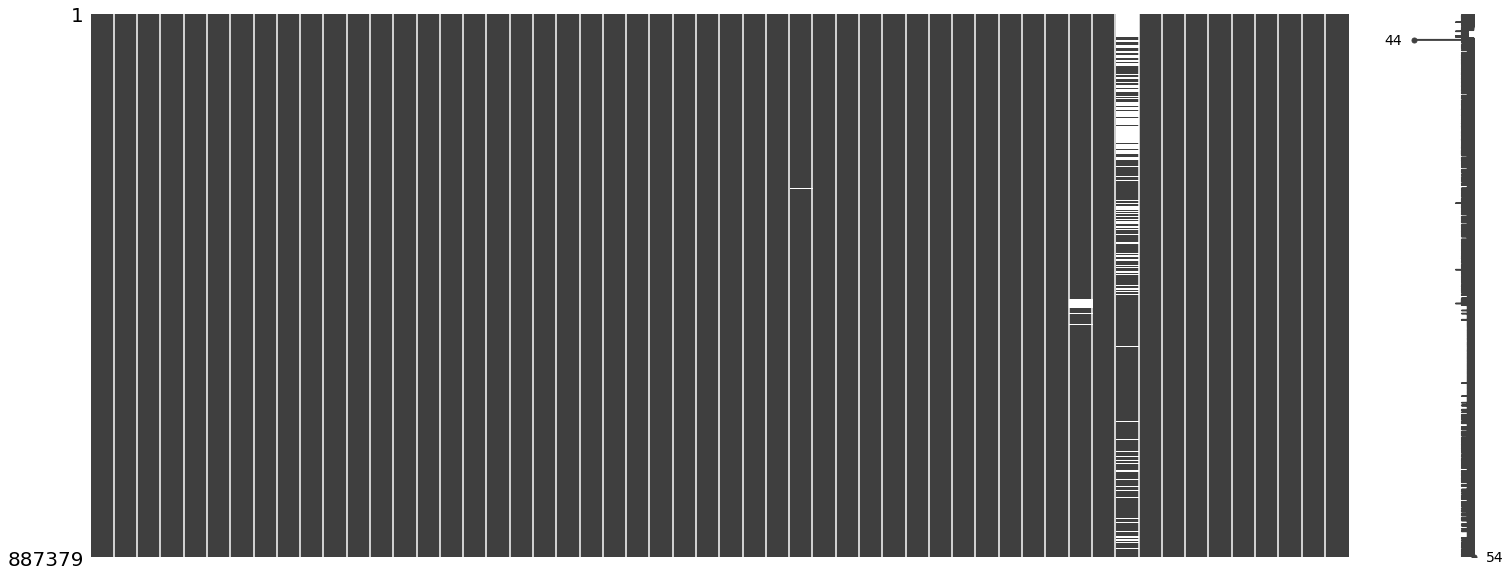

In [10]:
# resulting dataframe
mno.matrix(data)

### Summary

I have removed columns that were highly incomplete or not potentially useful for modeling.
Also, I imputed missing values for the following columns: mths_since_last_delinq, mths_since_last_record, mths_since_last_major_derog, tot_coll_amt, tot_cur_bal, total_rev_hi_lim

I have assumed that an NA value in the mnts_since_last_X columns means that the person has not had a report of X ever.

Potential TODOs: if using the last/next payment date colums, need to parse them into datetime format and think of a way to impute missing values. In addition, if using revol_util, think of a way to impute missing values. 

## Aggregations

I'm curious about the following questions:
- What does the typical borrower look like (how many loans, avg income level, home ownership, etc)?
- In this dataset, what is the mix of loan statuses? 
- How do grades and subgrades correspond to loan outcomes? 

In [11]:
data.iloc[0]

id                                                                       1077501
member_id                                                                1296599
loan_amnt                                                                   5000
funded_amnt                                                                 5000
funded_amnt_inv                                                             4975
term                                                                   36 months
int_rate                                                                   10.65
installment                                                               162.87
grade                                                                          B
sub_grade                                                                     B2
home_ownership                                                              RENT
annual_inc                                                                 24000
verification_status         

In [12]:
print(data.term.unique())
print(data.loan_status.unique())
print(data.pymnt_plan.unique())

[' 36 months' ' 60 months']
['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']
['n' 'y']


In [13]:
# loan entries per person
member_data = data.groupby('member_id')
member_counts = member_data.id.count()
print("members with more than one loan: %d" % len(member_counts[member_counts != 1]))

members with more than one loan: 0


In [14]:
# that's unusual, why are there no borrowers with >1 loan in this 8 year range? 
# it doesn't seem like the data are complete
# or a new member_id is assigned for each loan?

# I should do some data cleaning here to merge the two Charged Off and the two Fully Paid categories.
def clean_up_status(status):
    if "Charged Off" in status:
        return "Charged Off"
    if "Fully Paid" in status:
        return "Fully Paid"
    return status

data.loan_status = data.loan_status.apply(clean_up_status)

status_data = data.groupby('loan_status')
status_data_counts = status_data.id.count()
print(status_data_counts)
print() 

payment_plan_data = data.groupby('pymnt_plan')
print(payment_plan_data.id.count())
print() 

term_data = data.groupby('term')
print(term_data.id.count())

# parse the issue date
from dateutil.parser import parse
data['issue_d_datetime'] = data.issue_d.apply(parse)

loan_status
Charged Off            46009
Current               601779
Default                 1219
Fully Paid            209711
In Grace Period         6253
Issued                  8460
Late (16-30 days)       2357
Late (31-120 days)     11591
Name: id, dtype: int64

pymnt_plan
n    887369
y        10
Name: id, dtype: int64

term
 36 months    621125
 60 months    266254
Name: id, dtype: int64


 ### Delinquent fraction

Let's call a loan delinquent if it has passed into the late phase (after the grace period). Out of the loans that are still active, what is the fraction of loans that are delinquent vs current? Out of the loans that are completed, what is the fraction that are charged off vs fully paid? 

Note: based on LC's definitions of note status (https://help.lendingclub.com/hc/en-us/articles/215488038), I'll count "default" as an active loan.

In [15]:
# active
n_GOOD = status_data_counts['Current'] + status_data_counts['In Grace Period'] + \
         status_data_counts['Issued']
n_DELINQ = status_data_counts['Default'] + status_data_counts['Late (16-30 days)'] + \
        status_data_counts['Late (31-120 days)']
print('fraction of active loans delinquent: %3.2f%%' % (n_DELINQ*100/(n_DELINQ + n_GOOD)))


# has the loan matured?
data['term_mo'] = data['term'].apply(str.replace, args=('months', '')).apply(int)
data['mature_d'] = data['issue_d_datetime'] + data['term_mo'].apply(np.timedelta64, args=('M'))
data['issue_d_year'] = data.issue_d_datetime.apply(lambda x: x.year)


# completed
n_charged = status_data_counts['Charged Off']
n_paid = status_data_counts['Fully Paid']
print('fraction of completed loans charged off: %3.2f%%' % (n_charged*100/(n_charged + n_paid)))

# add these categories to the data frame
data['is_active'] = data.loan_status.apply(lambda x: 0 if (x == 'Charged Off' or x == 'Fully Paid') else 1)

fraction of active loans delinquent: 2.40%
fraction of completed loans charged off: 17.99%


### Takeaways

While most of the active loans are not delinquent, a large fraction of completed loans are charged-off. This discrepancy is definitely in the realm of possibility considering the 'completed' data represent 8 years of loans while the 'active' data are a snapshot of the current loans only. 

## Grading

Lending Club has a proprietary scoring system (using FICO and other things) for each borrower from A-G and subgrades from 1-5 in each of those levels. After some manipulation, I will look to see if there is a difference between these groups.

In [16]:
data.groupby('grade').id.count()

grade
A    148202
B    254535
C    245860
D    139542
E     70705
F     23046
G      5489
Name: id, dtype: int64

In [17]:
grade_map = {
    'A': 0, 'B': 1,
    'C': 2, 'D': 3,
    'E': 4, 'F': 5,
    'G': 6
}

def get_score(subgrade):
    """ 
    turn subgrade into an integer from 1-35
    """
    grade = subgrade[0]
    sub = int(subgrade[1])
    return 5 * grade_map[grade] + sub
    
data['loan_score'] = data.sub_grade.apply(get_score)

Text(0,0.5,'Frequency')

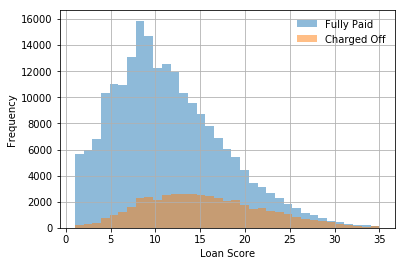

In [18]:
# grab loans that have been completed
loans_completed = data.loc[data.is_active == 0].copy()

paid = loans_completed.loc[loans_completed.loan_status == 'Fully Paid'].copy()
charged = loans_completed.loc[loans_completed.loan_status == 'Charged Off'].copy()

paid.loan_score.hist(bins=35, alpha=0.5, label='Fully Paid')
charged.loan_score.hist(bins=35, alpha=0.5, label='Charged Off')
plt.legend(frameon=False)
plt.xlabel('Loan Score')
plt.ylabel('Frequency')

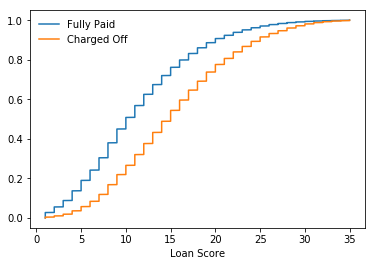

Ks_2sampResult(statistic=0.24894822930863147, pvalue=0.0)


In [19]:
# how different are these distributions?
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

cdf1 = ECDF(paid.loan_score)
plt.plot(cdf1.x, cdf1.y, label="Fully Paid")
cdf2 = ECDF(charged.loan_score)
plt.plot(cdf2.x, cdf2.y, label="Charged Off")
plt.legend(frameon=False)
plt.xlabel('Loan Score')
plt.show()

print(ks_2samp(paid.loan_score, charged.loan_score))


### Takeaways

Clearly, the two distributions (fully paid and charged off loans as a function of loan score) are significantly different. We can expect that loan score will be predictive of loan outcome. 

## Financial impact

Another thing to look at is the amount of total capital lost in each of these subgrades, given loans that have completed. 

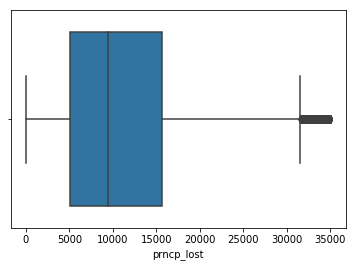

In [20]:
# try looking at out_prncp
#sns.boxplot(charged.out_prncp)

# out_prnpc has been set to 0 for the Charged Off group. Calculate it manually:
charged['prncp_lost'] = charged.loan_amnt - charged.total_rec_prncp
bp1 = sns.boxplot(charged.prncp_lost)

So about \$5k - \$15k is lost, from just the principal amount, when a borrower fails to pay off a loan. How does this break down by subgrade?

Text(0.5,0,'loan score')

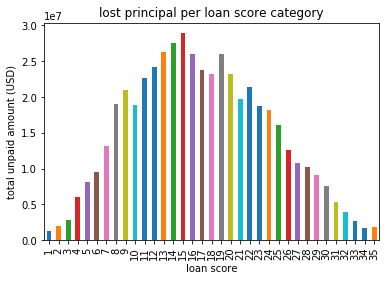

In [21]:
charged.groupby('loan_score').prncp_lost.sum().plot(kind='bar')
plt.title('lost principal per loan score category')
plt.ylabel('total unpaid amount (USD)')
plt.xlabel('loan score')

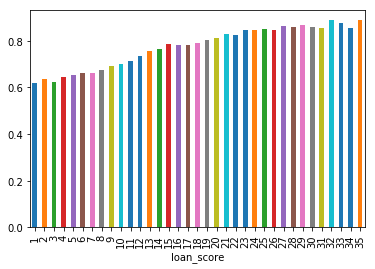

In [22]:
# is there a category that has a higher fraction of loss?
chargeoff_groups = charged.groupby('loan_score')
(chargeoff_groups.prncp_lost.sum()/chargeoff_groups.loan_amnt.sum()).plot(kind='bar')


### Takeaways

As expected, the fraction of lost pricipal becomes gradually higher with increasing loan risk.

## Income/Debt Profiles

Ttest_indResult(statistic=43.594478866796216, pvalue=0.0)


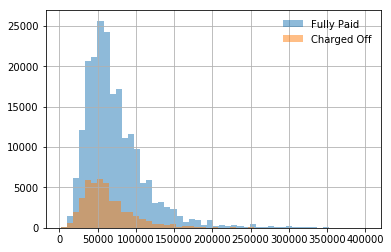

In [23]:
from scipy.stats import ttest_ind

paid_inc = paid.loc[paid.annual_inc < 400000].annual_inc
charged_inc = charged.loc[charged.annual_inc < 400000].annual_inc

paid_inc.hist(bins=50, alpha=0.5, label="Fully Paid")
charged_inc.hist(bins=50, alpha=0.5, label="Charged Off")
plt.legend(loc=0, frameon=False)

print(ttest_ind(paid_inc, charged_inc, equal_var=False, nan_policy='omit'))


Ttest_indResult(statistic=-54.488096117882584, pvalue=0.0)


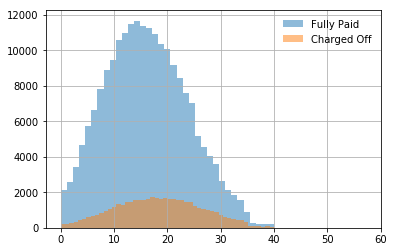

In [24]:
paid.dti.hist(bins=50, alpha=0.5, label="Fully Paid")
charged.dti.hist(bins=50, alpha=0.5, label="Charged Off")
plt.legend(loc=0, frameon=False)

print(ttest_ind(paid.dti, charged.dti, equal_var=False, nan_policy='omit'))



### Takeaways

Based on t-test statistics, there is a significant difference between the mean annual income and mean DTI percentage between the group of loans charged off versus paid fully. This can be useful for modeling. 

# Business Analysis

Let's zoom in on the 36 month loans and see how good of an investment they are.

Assumptions:
- Return = ((total payments) - (funded amount))/(funded amount)
- There are no taxes, fees, or inflation
- I calculate total return, not annual

In [25]:
data36 = data.loc[(data.term_mo == 36) & (data.mature_d < parse('2015-01-01'))].copy()
data36['returns'] = (data.total_pymnt - data.funded_amnt)/data.funded_amnt

print('Average 36-month loan return: %3.2f%%' % (data36.returns.mean()*100))

year_grade_groups = data36.groupby(['issue_d_year', 'grade'])


Average 36-month loan return: 7.93%


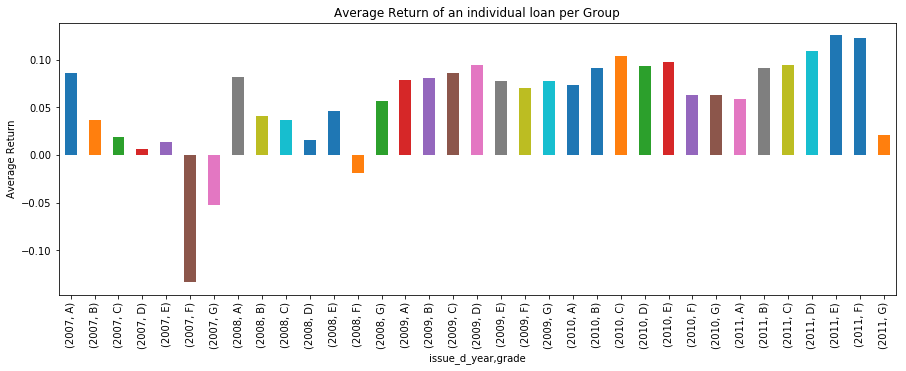

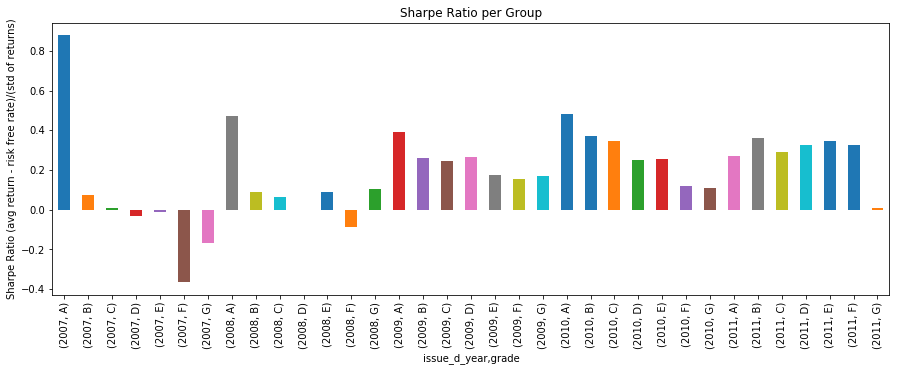

In [27]:
# average return on an individual loan
def get_avg_return(group):
    returns = (group.total_pymnt - group.funded_amnt)/group.funded_amnt
    return np.mean(returns)

plt.figure(figsize=(15,5))
avg_returns = year_grade_groups.returns.mean()
avg_returns.plot(kind='bar')
plt.title('Average Return of an individual loan per Group')
plt.ylabel('Average Return')
plt.show()


# sharpe ratio for each group
def get_sharpe_ratio(group):
    avg_return = np.mean(group.returns)
    sd = group.returns.std()
    # 3 month US treasury yield 3/22
    risk_free_rate = 0.0172
    return (avg_return - risk_free_rate)/sd

plt.figure(figsize=(15,5))    
year_grade_groups.apply(get_sharpe_ratio).plot(kind='bar')
plt.title('Sharpe Ratio per Group')
plt.ylabel('Sharpe Ratio (avg return - risk free rate)/(std of returns)')
plt.show()

### Takeaways

Around the 2007-2008 time period, the 'A' rated loans had the highest rate of return. As time went on, however, loans originated in the years 2009-2011 have shown consistently positive returns across the board, even in the high-risk F and G rating categories.  

The winner for highest rate of return is the (2011, 'E') group with a nearly 12.6% return (over 3 years). This may be a bit surprising, but is due to the fact that higher-risk loans have a higher interest rate.

# Modeling

My approach to the modeling of LC loan returns is to determine the strategy and evaluation metric first, followed by feature selection and model building. I would evaluate the model based on a benchmark and try to improve upon that. 

Some of the key insights:
- A model can help me decide whether or not a specific loan is worth buying. The strategy is then to use the model to "buy" attractive loans.
- I assume that each loan is available for purchase, held until maturity, and has no taxes, fees, etc. 
- I can treat the problem as a binary classification: will the loan be fully paid or charged off? If fully paid, buy and evaluate the model's returns compared to the benchmark above of ~8%. 
- Some other things to calculate and think about: volatility of returns, evaluating total portfolio returns (Sharpe ratio, M2, Sortino)

## Approach

- Narrow down data set to Fully Paid or Charged Off loans
- Train-test split
- Choose features that might be predictive: 
  - loan_amnt
  - term
  - int_rate
  - grade/sub_grade
  - home_ownership
  - annual_inc
  - verification_status
  - dti (debt to income percentage, lower better)
  - delinq_2yrs
  - inq_last_6mths
  - mths_since_last_delinq
  - mths_since_last_record 
  - mths_since_last_major_derog 
  - open_acc 
    - number of open credit lines in borrower's credit file
    - could one-hot encode to some categories like 0-10, 10-20, 20-30, 30+
  - pub_rec (map to 0, 1+, imbalanced)
  - total_acc
    - number of total credit lines in borrower's credit file
    - could one-hot encode to some categories like 0-10, 10-20, 20-30, 30+
  - initial_list_status (imbalanced)


In [28]:
cols_for_features = [
    'loan_amnt', 'term', 'int_rate', 'grade',
    'home_ownership', 'annual_inc', 'verification_status',
    'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
    'mths_since_last_record', 'mths_since_last_major_derog',
    'open_acc', 'pub_rec', 'total_acc', 'initial_list_status'
]

model_data = data.loc[(data.loan_status == 'Fully Paid') | (data.loan_status == 'Charged Off')].copy()
model_data['label'] = model_data.loan_status.apply(lambda x: 1 if x == 'Fully Paid' else 0)
labels = model_data.label.values

# check class imbalance
n_paid = model_data.loc[(data.loan_status == 'Fully Paid')].shape[0]
n_charged = model_data.loc[(data.loan_status == 'Charged Off')].shape[0]
print('class imbalance: ', n_paid/(n_paid + n_charged))

# difficult to impute the following values, so put the NANs in a new category
model_data.delinq_2yrs.fillna(-1, inplace=True)
model_data.inq_last_6mths.fillna(-1, inplace=True)
model_data.annual_inc.fillna(-1, inplace=True)
model_data.open_acc.fillna(-1, inplace=True)
model_data.total_acc.fillna(-1, inplace=True)
model_data.pub_rec.fillna(-1, inplace=True)

features = pd.get_dummies(model_data.loc[:,cols_for_features], 
                            columns=['home_ownership', 'verification_status', 
                                     'initial_list_status', 'grade', 'term'])
feature_names = features.columns.values


class imbalance:  0.8200805568590646


In [192]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, average_precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8)

params = {
    'n_estimators': [10, 25, 50],
    'max_features': ['sqrt', None],
    'min_samples_leaf': [1, 10, 50],
    'n_jobs': [4]
}
mod = GridSearchCV(RandomForestClassifier(), params, cv=5, verbose=1, scoring='precision')
mod.fit(X_train, y_train)

model = mod.best_estimator_
print(model)
feature_imp = mod.best_estimator_.feature_importances_
#print(feature_imp, feature_names)

/Users/janos/.local/share/virtualenvs/LendingClub-4R0Ub5G7/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [193]:
pred_proba = model.predict_proba(X_test)
pred_proba = pd.DataFrame(pred_proba)

predictions = model.predict(X_test)

print("Train Accuracy: ", accuracy_score(y_train, model.predict(X_train)))
print("Test Accuracy: ", accuracy_score(y_test, predictions))
print("Confusion matrix ", confusion_matrix(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, pred_proba.iloc[:,1], pos_label=1)

Train Accuracy:  0.991939425934616
Test Accuracy:  0.7872868762709213
Confusion matrix  [[ 1594  7570]
 [ 3309 38671]]


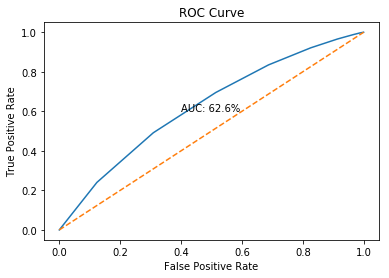

In [194]:
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
random_x = np.linspace(0,1,100)
plt.plot(random_x, random_x, '--')
auc = auc(fpr, tpr)
plt.text(.4, .6, "AUC: %3.1f%%" % (auc*100))
plt.show()

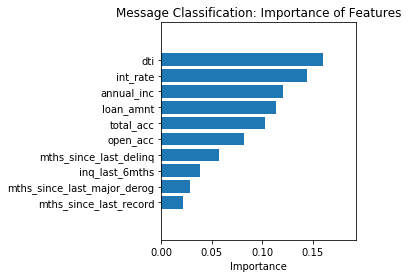

In [195]:
n_show = 10
importances = feature_imp
ix = np.argsort(importances)[::-1]
importances_sorted = importances[ix[0:n_show]]
feature_names_sorted = feature_names[ix[0:n_show]]

fig, ax = plt.subplots()
plt.title('Message Classification: Importance of Features')
plt.xlabel('Importance')
plt.margins(0.2)
plt.subplots_adjust(left=0.45)
y_pos = np.arange(n_show)
ax.barh(y_pos, importances_sorted, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names_sorted)
ax.invert_yaxis()
plt.show()

In [201]:
from sklearn.externals import joblib
joblib.dump(model, 'tuned_model.pkl') 


['tuned_model.pkl']

In [196]:
features_with_returns = features.copy()
features_with_returns['returns'] = (model_data.total_pymnt - model_data.funded_amnt)/model_data.funded_amnt
features_with_returns['predictions'] = model.predict(features)


In [197]:
def predict_row_roi(row):
    if row.predictions == 0:
        return 0
    return row.returns

features_with_returns['loan_roi'] = features_with_returns.apply(predict_row_roi, axis=1)


In [200]:
print("Average Return in Portfolio: %3.2f%%" % 
      (features_with_returns.loc[features_with_returns.predictions == 1].loan_roi.mean()*100))

Average Return in Portfolio: 10.85%


### Reflections

Was the model effective? Explain how you validated your model and discuss any uplift you see in the return generated.
- The model was successful in increasing the average loan return from 8% in the whole dataset to about 11% with the model driving our strategy to invest or not into a loan. I chose the Random Forest classifier because it is a robust, parallelizable algorithm that treats non-linearities in the data and allows for interpreting feature importances. I validated the model using 5-fold cross-validation and tuned the parameters using a grid search. I optimized for precision to make sure that I minimize the rate of false positives, which would bring down the average return in the portfolio. 

Please explain why you chose this approach over other alternatives.
- I chose to treat this problem as a binary classification because of the two distinct outcomes: paid vs. charged off. The classes were not too imbalanced (~82% fully paid), and classification is often more robust than regression. The feature importances are easy to calculate and interpret. I could have tried to predict what fraction of the loan was paid, but I was concerned that the errors would be high. In retrospect, given how much data there are, it may have been safe to do. 

Discuss any constraints this approach may have, and any next steps you would recommend.
- The main constraint of this approach is that the model is not tuned to global results (like total profit). I could have labeled the data by returns, instead of loan status, and tried to maximize "average return" or "total profit," both of which could be useful approaches. I would try these in order to potentially improve the model. Another constraint is assuming that loans can be bought individually, which may not be the case for institutional investors. Bundling subsets of the loans (by grade, for example) might be a more realistic problem to solve. Finally, I decided not to use XGBoost, which is my other go-to algorithm. This algorithm might be more successful, and is worth trying. 

- In terms of features, I would also try incorporating zip code / address state to localize the loan borrower and look for regional effects. I could have also used the loan score I calculated from grade and sub_grade to see if that is more predictive than grade alone. Finally, since loans can be sold before their maturity, it would be interesting to try to do this same modeling problem on active loans ("current", "late", "default" loan statuses) to determine whether we should keep or sell the note at any point in time during the lifetime of the loan.





